In [1]:
from torchvision import models
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import numpy as np
import Backbone_44
import Channel_Attention
import Spatial_Attention
import FC
import albumentations as A
import Face_Fake_Net
import pandas as pd

In [3]:
channel = Channel_Attention.Channel_Attention(channels = 2048)
backbone = Backbone_44.Backbone_44()
spatial = Spatial_Attention.Spatial_Attention()

In [5]:
x = backbone(image)
channel(x).shape

torch.Size([2, 2048, 7, 7])

In [8]:
x.shape

torch.Size([2, 2048, 7, 7])

(28, 28)

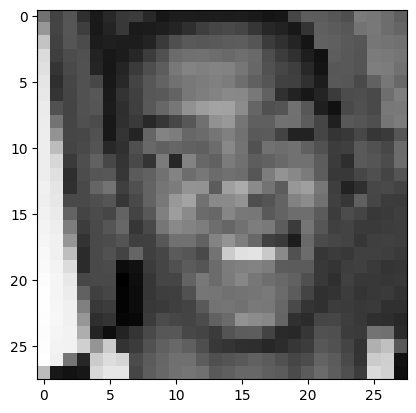

In [14]:
import cv2
import matplotlib.pyplot as plt


image = cv2.imread('/media/quocviet/New Volume/Comit/FAS/data/Face_Anti_Spoofing_Face_Fake_Net/check_point/image00050_depth.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image,(28,28))
plt.imshow(image, cmap = 'gray')
image.shape

In [3]:
df_error = pd.read_csv('../error.csv')
value_counts = df_error['spoof type'].value_counts()
print(value_counts)

spoof type
5    2883
7    2739
3     678
2     295
4     229
8     153
1     107
6      74
9      48
0      22
Name: count, dtype: int64


torch.Size([2, 3, 224, 224])

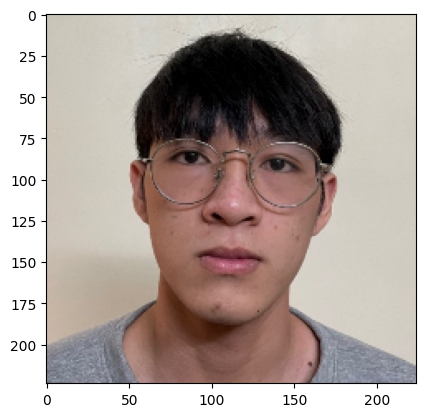

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

normalize_transform = A.Compose([
    # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.RandomBrightnessContrast(contrast_limit=0.05, brightness_limit=0.05, p = 1),
])

image = cv2.imread('D:\Comit\FAS\data\Test_image\live_6.jpg')
image = cv2.resize(image,(224,224))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = normalize_transform(image = image)['image']
plt.imshow(image)
image = image.astype(np.float32)
image = torch.tensor(image)
image = image.permute(2, 0, 1).unsqueeze(0)
image = torch.cat((image, image), dim=0)
image = image.to(device)
image.shape

In [3]:
image.shape

torch.Size([2, 3, 224, 224])

In [4]:
channel = Channel_Attention.Channel_Attention(channels = 2048)
backbone = Backbone_44.Backbone_44()
spatial = Spatial_Attention.Spatial_Attention()
net = Face_Fake_Net.Face_Fake_Net()
tmp = torch.load('/media/quocviet/New Volume/Comit/FAS/data/Face_Anti_Spoofing_Face_Fake_Net/check_point/0_GPU_FULL_best_check_point.pth',map_location='cuda:0')
# tmp = torch.load('/media/quocviet/New Volume/Comit/FAS/data/Face_Anti_Spoofing_Face_Fake_Net/check_point/0_GPU_200K_test_best_check_point.pth', map_location=lambda storage, loc: storage)
corrected_dict = {}
def fix_key(wrong_key):
    return wrong_key.replace('module.', "")
for wrong_key, value in tmp.items():
    correct_key = fix_key(wrong_key)  # Replace fix_key with your function to fix keys
    corrected_dict[correct_key] = value
net.load_state_dict(corrected_dict)
net.to(device);
net.eval();
# # channel.to(device)
# # spatial.to(device)
# # x = backbone(image)
# # x = spatial(x)
# # x.shape

/home/quocviet/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/quocviet/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
image.shape

torch.Size([2, 3, 224, 224])

In [27]:
def check(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = normalize_transform(image = image)['image']
    image = image.astype(np.float32)
    image = torch.tensor(image)
    image = image.permute(2, 0, 1).unsqueeze(0)
    # image = torch.cat((image, image), dim=0)
    image = image.to(device)
    prob = net(image)
    # print(torch.softmax(prob, dim  = 1))
    return (torch.argmax(torch.softmax(prob, dim = 1)).item() == 0)

check('/media/quocviet/SSD Data/Viet_FAS/CelebA_Spoof/image_preprocessed/spoof_face/494420.png')

True

import pandas as pd

df = pd.read_csv("/media/quocviet/SSD Data/Viet_FAS/CelebA_Spoof/image_preprocessed/annotation/test_annotation.csv")
# df = df[-1000:]
count = 0
APCER = 0
BPCER = 0
n_real_1 = 0
n_real_0 = 0
for i in range(len(df)):
    path, label = df.iloc[i][0], df.iloc[i][1]
    # print(path, label)
    path = '/media/quocviet/SSD Data/Viet_FAS/CelebA_Spoof/' + path
    if label != 0: 
        label = 1
        n_real_1 += 1
    else:
        n_real_0 += 1
        
    prediction = check(path)    
    if prediction == True:
        prediction = 0
    else:
        prediction = 1
        
    if prediction == label:
        count += 1
    
    if prediction == 0 and label == 1:
        APCER += 1
    if prediction == 1 and label == 0:
        BPCER += 1
     
APCER = APCER/n_real_1 *100   
BPCER = BPCER/n_real_0 *100     
print("Test Set Size: ", len(df))
print("Accuracy: ", count/len(df) * 100)
print("APCER: ", APCER)
print("BPCER: ", BPCER)
print("ACER: ", (APCER + BPCER) / 2)

### Biểu đồ

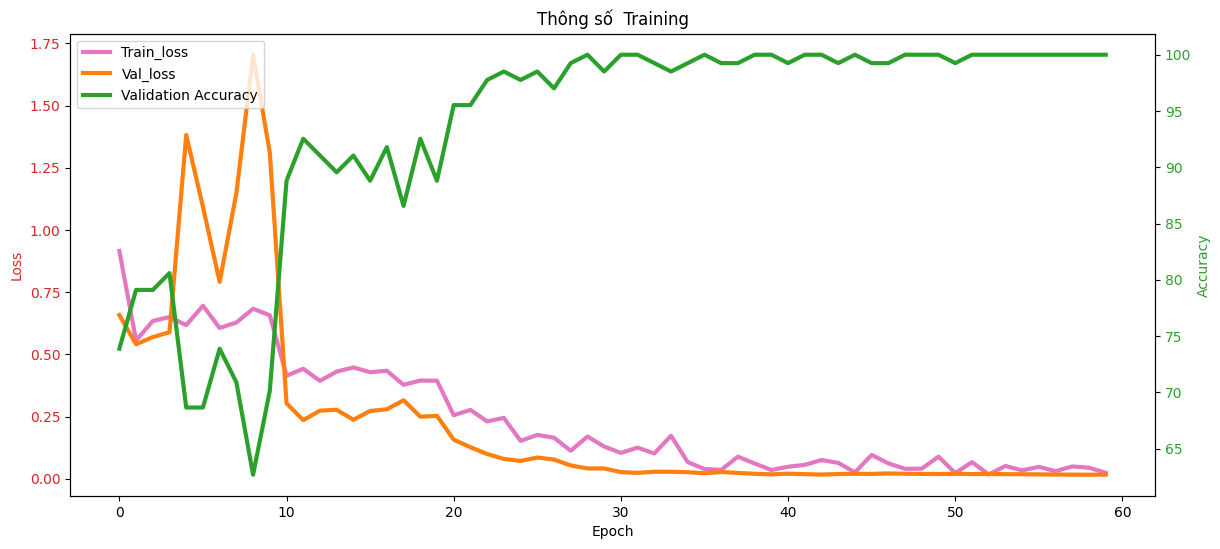

Max Training Loss:  0.9157405495643616
Min Training Loss:  0.017162663862109184 

Max Validation Loss:  1.704563856124878
Min Validation Loss:  0.01607411913573742 

Min Validation Loss:  62.68656716417911
Max Validation Accuracy:  100.0 



In [22]:
file_1 = open('../val_accuracy/1_val_accuracy.txt')
line_1 = file_1.readline().split(' ')
file_2 = open('../train_loss/1_train_loss.txt')
line_2 = file_2.readline().split(' ')
file_3 = open('../val_loss/1_val_loss.txt')
line_3 = file_3.readline().split(' ')

for i in range(len(line_1)):
    line_1[i] = float(line_1[i])
    line_2[i] = float(line_2[i])
    line_3[i] = float(line_3[i])

x = list(range(len(line_1)))

fig, ax1 = plt.subplots(figsize=(14, 6))

# Vẽ Loss trên trục tung bên trái
ax1.plot(x, line_2, label='Train_loss', color='tab:pink', linewidth= 3)
ax1.plot(x, line_3, label='Val_loss', color='tab:orange', linewidth= 3)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Tạo một trục tung thứ hai cho val
ax2 = ax1.twinx()
ax2.plot(x, line_1, label='Validation Accuracy', color='tab:green', linewidth= 3)
ax2.set_ylabel('Accuracy', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Tiêu đề
plt.title('Thông số  Training')
# Hiển thị chú thích
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

# Hiển thị biểu đồ
plt.show()
print("Max Training Loss: ", max(line_2))
print("Min Training Loss: ", min(line_2), '\n')

print("Max Validation Loss: ", max(line_3))
print("Min Validation Loss: ", min(line_3), '\n')

print("Min Validation Loss: ", min(line_1))
print("Max Validation Accuracy: ", max(line_1), '\n')